/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D Loss: 0.7069, G Loss: 0.7408
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━

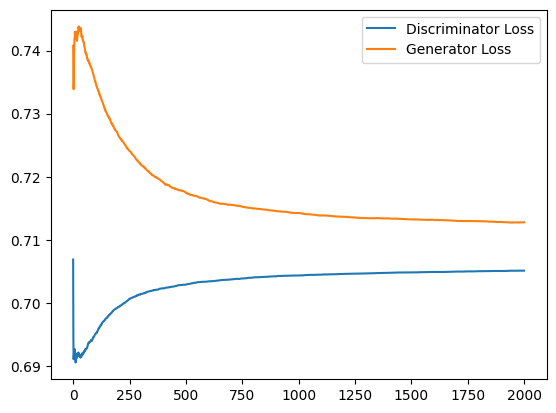

In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam

# Load data
def load_data():
    with open("subplaces.json", "r") as f:
        places = json.load(f)
    with open("subreviews.json", "r") as f:
        reviews = json.load(f)
    return places, reviews

places, reviews = load_data()

# Data Preprocessing
def preprocess_data(places, reviews):
    place_features = []
    user_preferences = {}
    unique_categories = set()

    for place in places:
        categories = place["categories"].split(",")
        unique_categories.update(categories)
        place_features.append([
            place["latitude"], place["longitude"],
            place["stars"], place["review_count"]
        ])

    unique_categories = list(unique_categories)

    for review in reviews:
        user_id = review["user_id"]
        business_id = review["business_id"]
        score = review["score"]
        category = next((p["categories"] for p in places if p["business_id"] == business_id), None)

        if user_id not in user_preferences:
            user_preferences[user_id] = {"min_rating": 0, "category_scores": {}}

        user_preferences[user_id]["min_rating"] += score

        if category:
            for cat in category.split(","):
                if cat not in user_preferences[user_id]["category_scores"]:
                    user_preferences[user_id]["category_scores"][cat] = []
                user_preferences[user_id]["category_scores"][cat].append(score)

    for user in user_preferences:
        user_preferences[user]["min_rating"] /= max(len(user_preferences[user]["category_scores"]), 1)
        for cat in user_preferences[user]["category_scores"]:
            user_preferences[user]["category_scores"][cat] = np.mean(user_preferences[user]["category_scores"][cat])

    return np.array(place_features), user_preferences, unique_categories

places_data, user_data, unique_categories = preprocess_data(places, reviews)

# Normalize data
scaler = MinMaxScaler()
places_scaled = scaler.fit_transform(places_data)

# Define GAN Components
latent_dim = 10
user_input_dim = len(unique_categories) + 1
place_input_dim = places_scaled.shape[1]

# Generator
def build_generator(latent_dim, user_input_dim, place_input_dim):
    noise_input = Input(shape=(latent_dim,))
    user_input = Input(shape=(user_input_dim,))
    combined = Concatenate()([noise_input, user_input])
    x = Dense(128)(combined)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output = Dense(place_input_dim, activation='sigmoid')(x)
    return Model([noise_input, user_input], output)

# Discriminator
def build_discriminator(user_input_dim, place_input_dim):
    user_input = Input(shape=(user_input_dim,))
    place_input = Input(shape=(place_input_dim,))
    combined = Concatenate()([user_input, place_input])
    x = Dense(128)(combined)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)  # Helps prevent discriminator overpowering
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model([user_input, place_input], output)

# GAN Compilation
def build_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False
    noise_input = Input(shape=(latent_dim,))
    user_input = Input(shape=(user_input_dim,))
    generated_place = generator([noise_input, user_input])
    validity = discriminator([user_input, generated_place])
    gan = Model([noise_input, user_input], validity)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return gan

generator = build_generator(latent_dim, user_input_dim, place_input_dim)
discriminator = build_discriminator(user_input_dim, place_input_dim)
gan = build_gan(generator, discriminator)

# Training
num_epochs = 2000
batch_size = 32
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    user_batch_ids = np.random.choice(list(user_data.keys()), batch_size, replace=True)
    user_input_batch = np.array([
        [user_data[user]["min_rating"]] + [user_data[user]["category_scores"].get(cat, 0) for cat in unique_categories]
        for user in user_batch_ids
    ])
    place_batch = np.random.choice(len(places_scaled), batch_size, replace=True)
    place_data_batch = places_scaled[place_batch]
    latent_noise = np.random.randn(batch_size, latent_dim)

    generated_places = generator.predict([latent_noise, user_input_batch])

    real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing
    fake_labels = np.zeros((batch_size, 1)) + 0.1

    d_loss_real = discriminator.train_on_batch([user_input_batch, place_data_batch], real_labels)
    d_loss_fake = discriminator.train_on_batch([user_input_batch, generated_places], fake_labels)
    g_loss = gan.train_on_batch([latent_noise, user_input_batch], real_labels)

    d_losses.append((d_loss_real[0] + d_loss_fake[0]) / 2)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_losses[-1]:.4f}, G Loss: {g_loss:.4f}")

# Plot Losses
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam

# Load data
def load_data():
    with open("subplaces.json", "r") as f:
        places = json.load(f)
    with open("subreviews.json", "r") as f:
        reviews = json.load(f)
    return places, reviews

places, reviews = load_data()

# Data Preprocessing
def preprocess_data(places, reviews):
    place_features = []
    user_preferences = {}
    unique_categories = set()

    for place in places:
        categories = place["categories"].split(",")
        unique_categories.update(categories)
        place_features.append([
            place["latitude"], place["longitude"],
            place["stars"], place["review_count"]
        ])

    unique_categories = list(unique_categories)

    for review in reviews:
        user_id = review["user_id"]
        business_id = review["business_id"]
        score = review["score"]
        category = next((p["categories"] for p in places if p["business_id"] == business_id), None)

        if user_id not in user_preferences:
            user_preferences[user_id] = {"min_rating": 0, "category_scores": {}}

        user_preferences[user_id]["min_rating"] += score

        if category:
            for cat in category.split(","):
                if cat not in user_preferences[user_id]["category_scores"]:
                    user_preferences[user_id]["category_scores"][cat] = []
                user_preferences[user_id]["category_scores"][cat].append(score)

    for user in user_preferences:
        user_preferences[user]["min_rating"] /= max(len(user_preferences[user]["category_scores"]), 1)
        for cat in user_preferences[user]["category_scores"]:
            user_preferences[user]["category_scores"][cat] = np.mean(user_preferences[user]["category_scores"][cat])

    return np.array(place_features), user_preferences, unique_categories

places_data, user_data, unique_categories = preprocess_data(places, reviews)

# Normalize data
scaler = MinMaxScaler()
places_scaled = scaler.fit_transform(places_data)

# Define GAN Components
latent_dim = 10
user_input_dim = len(unique_categories) + 1
place_input_dim = places_scaled.shape[1]

# Generator
def build_generator(latent_dim, user_input_dim, place_input_dim):
    noise_input = Input(shape=(latent_dim,))
    user_input = Input(shape=(user_input_dim,))
    combined = Concatenate()([noise_input, user_input])
    x = Dense(128)(combined)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output = Dense(place_input_dim, activation='sigmoid')(x)
    return Model([noise_input, user_input], output)

# Discriminator
def build_discriminator(user_input_dim, place_input_dim):
    user_input = Input(shape=(user_input_dim,))
    place_input = Input(shape=(place_input_dim,))
    combined = Concatenate()([user_input, place_input])
    x = Dense(128)(combined)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)  # Helps prevent discriminator overpowering
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model([user_input, place_input], output)

# GAN Compilation
def build_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False
    noise_input = Input(shape=(latent_dim,))
    user_input = Input(shape=(user_input_dim,))
    generated_place = generator([noise_input, user_input])
    validity = discriminator([user_input, generated_place])
    gan = Model([noise_input, user_input], validity)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return gan

generator = build_generator(latent_dim, user_input_dim, place_input_dim)
discriminator = build_discriminator(user_input_dim, place_input_dim)
gan = build_gan(generator, discriminator)

# Training
num_epochs = 2000
batch_size = 32
d_losses = []
g_losses = []

for epoch in range(num_epochs):
    user_batch_ids = np.random.choice(list(user_data.keys()), batch_size, replace=True)
    user_input_batch = np.array([
        [user_data[user]["min_rating"]] + [user_data[user]["category_scores"].get(cat, 0) for cat in unique_categories]
        for user in user_batch_ids
    ])
    place_batch = np.random.choice(len(places_scaled), batch_size, replace=True)
    place_data_batch = places_scaled[place_batch]
    latent_noise = np.random.randn(batch_size, latent_dim)

    generated_places = generator.predict([latent_noise, user_input_batch])

    real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing
    fake_labels = np.zeros((batch_size, 1)) + 0.1

    d_loss_real = discriminator.train_on_batch([user_input_batch, place_data_batch], real_labels)
    d_loss_fake = discriminator.train_on_batch([user_input_batch, generated_places], fake_labels)
    g_loss = gan.train_on_batch([latent_noise, user_input_batch], real_labels)

    d_losses.append((d_loss_real[0] + d_loss_fake[0]) / 2)
    g_losses.append(g_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_losses[-1]:.4f}, G Loss: {g_loss:.4f}")

# Evaluate Model
num_test_users = 50
test_user_ids = np.random.choice(list(user_data.keys()), num_test_users, replace=False)

test_user_input = np.array([
    [user_data[user]["min_rating"]] + [user_data[user]["category_scores"].get(cat, 0) for cat in unique_categories]
    for user in test_user_ids
])

latent_noise = np.random.randn(num_test_users, latent_dim)
generated_places = generator.predict([latent_noise, test_user_input])
generated_places_denorm = scaler.inverse_transform(generated_places)

r2 = r2_score(places_data[:num_test_users], generated_places_denorm)
adjusted_r2 = 1 - ((1 - r2) * (num_test_users - 1) / (num_test_users - place_input_dim - 1))
rmse = np.sqrt(mean_squared_error(places_data[:num_test_users], generated_places_denorm))
mae = mean_absolute_error(places_data[:num_test_users], generated_places_denorm)

print(f"R² Score: {r2:.4f}")
print(f"Adjusted R² Score: {adjusted_r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D Loss: 0.7317, G Loss: 0.7493
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━